# creating your own dataset with Google Images

Search for something in [Google Images](images.google.com), then hit Ctrl + SHIFT + J, paste this snippet of code:

```
urls = Array.from(document.querySelectorAll(".rg_di .rg_meta")).map(el=>JSON.parse(el.textContent).ou);
window.open("data:text/csv;charset=utf-8," + escape(urls.join("\n")));
```

to download a CSV with links of the images

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
folder = "teddy"
file = "teddy_bears.csv"

In [3]:
folder = "black"
file = "black_bears.csv"

In [4]:
folder = "brown"
file = "brown_bears.csv"

In [5]:
path = Path("data/bears")
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [6]:
download_images(path/file, dest, max_pics=200)

In [7]:
classes = ["teddy", "black", "brown"]

In [8]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(
    path, train=".", valid_pct=0.2,
    ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
data.classes

['black', 'brown', 'teddy']

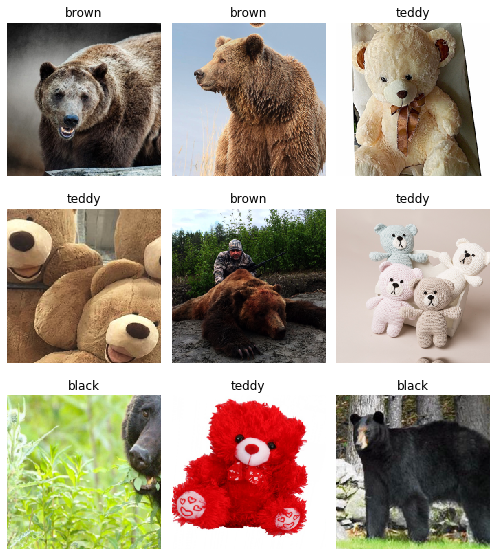

In [11]:
data.show_batch(rows=3, figsize=(7, 8))

In [12]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'brown', 'teddy'], 3, 439, 109)

# define a model

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.072657,0.194232,0.064220,00:14
1,0.622734,0.138186,0.055046,00:13
2,0.439928,0.138916,0.055046,00:14
3,0.344770,0.140466,0.064220,00:13


In [15]:
learn.save("stage-1")

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


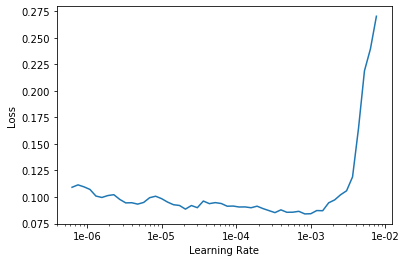

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.104083,0.259132,0.064220,00:15
1,0.122739,0.290891,0.082569,00:15


In [20]:
learn.save("stage-2")

# interpretation

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

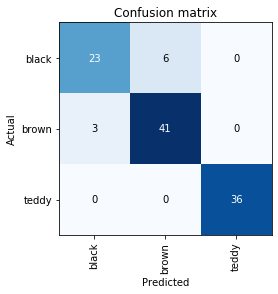

In [22]:
interp.plot_confusion_matrix()

# cleaning up

some of the top losses aren't due to bad performance of the model, but images that shouldn't be there.

Using the `FileDeleter` widget, we can prune our top losses, removing photos that don't belong

In [23]:
from fastai.widgets import *

losses, idx = interp.top_losses()
top_losses_paths = data.valid_ds.x[idx]

In [24]:
# ic = ImageCleaner(top_losses_paths.path, top_losses_paths, idx)

In [25]:
ds, idxs = DatasetFormatter().from_toplosses(learn)

In [26]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# production

most cases you would want to run inference on a model using CPU, you could do so using:

In [28]:
defaults.device = torch.device("cpu")

In [29]:
data.classes

['black', 'brown', 'teddy']

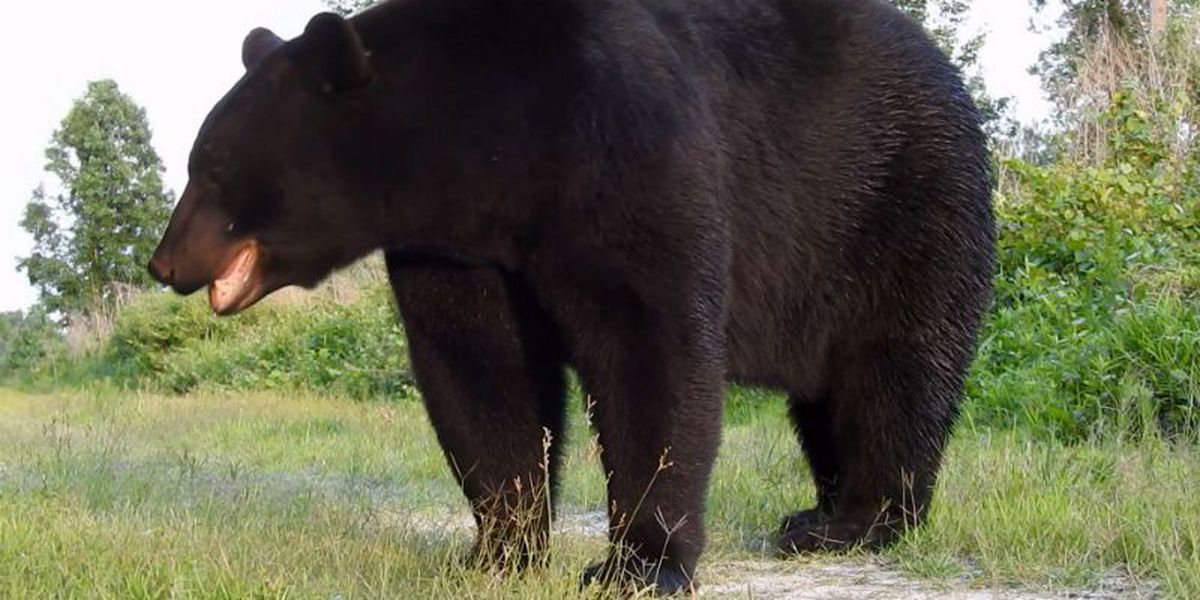

In [31]:
img = open_image(path/"black"/"00000191.jpg")
img

In [33]:
data2 = ImageDataBunch.single_from_classes(path, data.classes, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load("stage-2")

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/bears;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/bears;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(


In [34]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category black

# things can go wrong

Most of the time you will train fine with the defaults

But,

Sometimes you might want to tune the learning rate and the number of epochs

### learning rate too high

In [38]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [39]:
learn.fit_one_cycle(1, max_lr=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,15.656884,91091304.000000,0.596330,00:14


### learning rate too low

In [40]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [42]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,1.568464,1.342363,0.770642,00:16
1,1.605190,1.275478,0.697248,00:17
2,1.541571,1.232836,0.688073,00:15
3,1.519251,1.213226,0.651376,00:13
4,1.498838,1.212436,0.651376,00:13


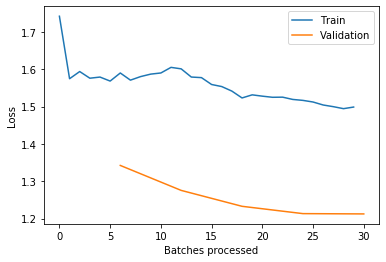

In [44]:
learn.recorder.plot_losses()

### too few epochs

In [45]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/home/jayme/miniconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [46]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.661786,0.135607,0.045872,00:16


### too many epochs aka overfitting

In [47]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [48]:
learn.fit_one_cycle(20, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.521785,1.323473,0.779817,00:15
1,1.514941,1.219909,0.678899,00:17
2,1.487339,1.081980,0.577982,00:15
3,1.407365,0.892777,0.422018,00:16
4,1.301906,0.684180,0.293578,00:16
5,1.175558,0.523063,0.183486,00:16
6,1.073420,0.412676,0.128440,00:16
7,0.982784,0.341383,0.100917,00:16
8,0.891417,0.295873,0.091743,00:15
9,0.809764,0.265942,0.091743,00:15
